In [1]:
import itertools
import os
from collections import namedtuple

import luigi
import dill
import numpy as np
from scipy.stats import binom

from experiment_framework.helpers import AllAsymptotics, \
load_completed_AAs_into_dataframe, load_completed_CCCs_into_dataframe
from empirical_privacy import one_bit_sum, config

from notebook_context import *

### Run experiments

In [2]:
n = 1
p = 0.60
d = 3
ds = {
    'n_trials': n, 'prob_success': p, 'gen_distr_type': 'multidim_binom',
}
asys = {
    'gen_sample_kwargs'  : {'generate_in_batch': True,
                            'x_concatenator': 'numpy.vstack'
                           },
    'fitter'             : 'knn',
    # we use random tie-breaking since the samples are discrete
    'fitter_kwargs'      : {'neighbor_method': 'gyorfi'},
    'n_docs'                : 100,
    'n_trials_per_training_set_size': 100,
    'n_max'              : 2**8,
    'validation_set_size': 2**8,
    'p'                  : 0.9,  # for bootstrap
    'n_bootstraps'       : 1000,  # for bootstrap,
    'in_memory'          : True
}
fit_model = asys['fitter_kwargs']['neighbor_method']

All = AllAsymptotics(
        gen_sample_path='empirical_privacy.one_bit_sum.GenSampleOneBitSum',
        dataset_settings=ds,
        asymptotic_settings=asys)
CCCs = [AA.requires()['CCC'] for AA in All.requires()]

/opt/conda/lib/python3.6/site-packages/luigi/parameter.py:261: UserWarning: Parameter "random_seed" with value "0" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
/opt/conda/lib/python3.6/site-packages/luigi/parameter.py:261: UserWarning: Parameter "random_seed" with value "0" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
/opt/conda/lib/python3.6/site-packages/luigi/parameter.py:261: UserWarning: Parameter "random_seed" with value "0" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
/opt/conda/lib/python3.6/site-packages/luigi/parameter.py:261: UserWarning: Parameter "random_seed" with value "0" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
/opt/conda/lib/python3.6/sit

In [ ]:
# # uncomment to delete outputs and dependencies to re-run the experiments
# for AA in All.requires():
#     AA.delete_outputs()
#     AA.delete_deps()
# for CCC in CCCs:
#     CCC.delete_outputs()
#     CCC.delete_deps()

In [3]:
luigi.build(CCCs, workers=16, log_level='ERROR', local_scheduler=True)  # compute CCCs using 16 workers since they're single threaded
luigi.build([All], local_scheduler=True, workers=2, log_level='ERROR')

/opt/conda/lib/python3.6/site-packages/luigi/parameter.py:261: UserWarning: Parameter "task_process_context" with value "None" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))


True

In [4]:
AAs = All.requires()
DF = load_completed_AAs_into_dataframe(AAs)
n_docs = DF.doc_ind.nunique()
DF = DF[DF.n_max==DF.n_max.max()]

---

### Compute $P(Correct)$ based on stat dist

In [5]:
from scipy.special import comb
def multidim_binom_stat_dist(p, d):
    q = 1-p
    n_combos = 2**d
    stat_dist = 0
    for k in range(d+1):
        n_combos_with_k = comb(d, k)
        p_1 = n_combos_with_k * p**k * q**(d-k)
        p_2 = n_combos_with_k * q**k * p**(d-k)
        delta_prob = np.abs(p_1 - p_2)
        stat_dist += delta_prob
    return 0.5*stat_dist
        

pc = 0.5+0.5*multidim_binom_stat_dist(p, 3)
print(pc)

0.648


In [6]:
DF.head()

,confidence_interval_prob,doc_ind,gen_distr_type,in_memory,knn_curve_model,lb_one_sided,lb_two_sided,lower_bound,n_bootstraps,n_max,n_trials,n_trials_per_training_set_size,prob_success,ub_one_sided,ub_two_sided,upper_bound,validation_set_size
0,0.9,0,multidim_binom,True,gyorfi,0.633682,0.629278,0.629278,1000,256,1,100,0.6,0.669357,0.673614,0.673614,256
1,0.9,1,multidim_binom,True,gyorfi,0.641302,0.635935,0.635935,1000,256,1,100,0.6,0.678753,0.684983,0.684983,256
2,0.9,2,multidim_binom,True,gyorfi,0.615163,0.610922,0.610922,1000,256,1,100,0.6,0.651635,0.656408,0.656408,256
3,0.9,3,multidim_binom,True,gyorfi,0.623575,0.619462,0.619462,1000,256,1,100,0.6,0.655938,0.660127,0.660127,256
4,0.9,4,multidim_binom,True,gyorfi,0.614442,0.609253,0.609253,1000,256,1,100,0.6,0.650121,0.656645,0.656645,256


In [7]:
n_success = DF[DF['upper_bound']>=pc].shape[0]
n_failed = DF[DF['upper_bound']<pc].shape[0]
n_total = n_success + n_failed

print(f"""Success probability {n_success/n_total:.2f} over {n_total} trials
with bootstrap confindence interval probability of {asys["p"]:.2f}.""")

Success probability 0.90 over 100 trials
with bootstrap confindence interval probability of 0.90.


### Plot outcomes for all trials

In [8]:
configure_plotting_for_publication()


import pandas as pd

from scipy.optimize import least_squares


from experiment_framework.asymptotic_analysis import asymptotic_privacy_lr, transform_n_to_k_for_knn, asymptotic_curve

from experiment_framework.privacy_estimator_mixins import get_k

SAVE_FIGURES_FOR_LATEX = False

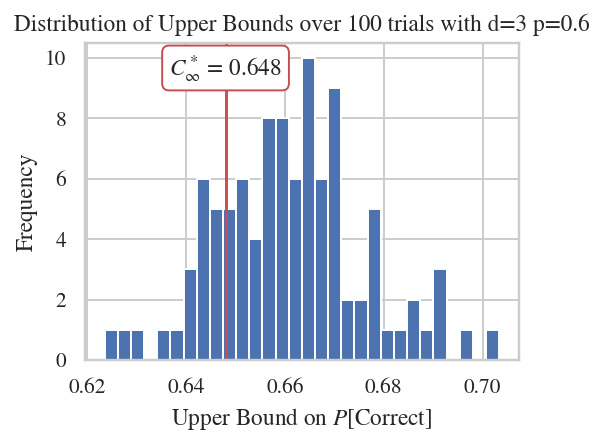

In [9]:
ax = DF.ub_one_sided.plot(kind='hist', bins=30)
true_ub = pc
plt.axvline(x=true_ub, color='r')
plt.text(x=true_ub,
         y=0.9,
         s='$C_\infty^*$ = {:.3f}'.format(true_ub),
         transform=x_data_y_axis(),
         horizontalalignment='center',
         bbox=dict(facecolor='w', edgecolor='r', boxstyle='round')
        )
plt.xlabel('Upper Bound on $P[$Correct$]$')
plt.title('Distribution of Upper Bounds over {ntri} trials with d={d} p={p}'.format(
    ntri=asys['n_docs'],
    d=d,
    p=p
))

if SAVE_FIGURES_FOR_LATEX:
    plt.title('')
    plt.ylabel('Frequency')
    plt.xlabel('Estimated Upper Bound on $C^*_\infty$')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_PATH, 'experiment_1_upper_bound_histogram.eps'))

### Plot the details for a single trial

In [ ]:
CCCs[0]

In [ ]:
list(CCCs[0].requires().values())[0].requires()['model'].neighbor_method

In [ ]:
DFccc = load_completed_CCCs_into_dataframe(CCCs)
print(DFccc.shape)

In [ ]:
from functools import reduce

def get_bootstrap_model(DF, doc_ind, d=d):
    if doc_ind is not None:
        DF = DF.loc[DF.doc_ind == doc_ind, :]
    DF.loc[DF.classifier_accuracy < 0.5, 'classifier_accuracy'] = 0.5
    
    X = []
    y = []
    n_expected = DF.training_set_size.nunique()

    for (gn, SG) in DF.groupby('trial'):
        tss = SG.training_set_size.values[np.newaxis, :]
        if tss.size != n_expected:
            continue
        X.append(tss)
        y.append(SG.classifier_accuracy.values[np.newaxis, :])

    X = reduce(lambda x,y : np.vstack((x,y)), X).astype(np.double)
    y = reduce(lambda x,y : np.vstack((x,y)), y).astype(np.double)
    
    return X, y

In [ ]:
confidence_interval_prob = 0.9
    
def plot_CCC_DF(DF, doc_ind=None, d=d, fit_model=fit_model):
    global SAVE_FIGURES_FOR_LATEX
    print('Training set sizes = ',
          DF.training_set_size.min(),
          '--',
          DF.training_set_size.max()
         )
    if doc_ind is not None:
        DF = DF.loc[DF.doc_ind == doc_ind, :]
    DF.loc[DF.classifier_accuracy < 0.5, 'classifier_accuracy'] = 0.5
    n_docs = DF.doc_ind.nunique()
    cp = sns.color_palette('hls', n_docs, desat=0.9)
    handle = sns.scatterplot(
        data=DF,
        x='training_set_size',
        y='classifier_accuracy',
        hue='doc_ind',
        legend=None,
        palette=cp,
    
    )
   
    # curve for all the data
    x = DF.training_set_size.values.astype(np.double)
    y = DF.classifier_accuracy.values
    
    
    # bootstrap for ub
    tss, accu = get_bootstrap_model(DF, doc_ind)
    ks = transform_n_to_k_for_knn(tss, fit_model, d=d)
    m, C = asymptotic_curve(ks.reshape(ks.size), accu.reshape(accu.size))
    print(f'm={m} C={C}')
    boot_res = empirical_bootstrap_bounds(training_set_sizes=tss,
                                      d=d,
                                      fit_model=fit_model,
                                      classifier_accuracies=accu,
                                      confidence_interval_prob=0.99,
                                      n_bootstraps=100)
    delta_means = boot_res['delta_means']
    samples = boot_res['mean'] - boot_res['delta_means']
    assert boot_res['mean'] == m

    ub = boot_res['ub_one_sided']
    base = config.SAMPLES_BASE
    xx = np.logspace(np.log(np.min(x))/np.log(base),
                     np.log(np.max(x))/np.log(base),
                    base=base)
    kks = transform_n_to_k_for_knn(xx, fit_model, d=d)
    plt.plot(xx, m+C*kks, '-g')
    
    labeled_axhline(ub, 'U.B.', 'k', handle)
    labeled_axhline(m, '$E[C_\infty]$', 'g', handle, linestyle='--')
    labeled_axhline(pc, '$C_\infty^*$', 'r', handle)
    
    plt.xticks(x, ['$2^{%s}$'%'{:}'.format(int(np.log(xx)/np.log(2))) for xx in x],
              rotation=30)
    
    if SAVE_FIGURES_FOR_LATEX:
        plt.xlabel('Training Set Size')
        plt.ylabel('P[correct]')
    
    ax2 = handle.twiny()
    ax2.set_xlim(0, 100.0)
    ax2.set_xticks([])
    sns.distplot(a=samples,
                 bins=30,
                 hist=True,
                 hist_kws={'alpha':0.30},
                 norm_hist=True,
                 kde=False,
                 kde_kws={'linestyle':':', 'alpha':0.75},
                 rug=False,
                 vertical=True,
                 color='g',
                ax=ax2)
    
    plt.ylim([0.6, 0.65])

    if SAVE_FIGURES_FOR_LATEX:
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_PATH, 'experiment_1_bootstrap_visualization.png'))


    
# call the function
plot_CCC_DF(DFccc, 0)


### Debugging bootstrap:

In [ ]:
tss, accu = get_bootstrap_model(DFccc, 1)

boot_res = empirical_bootstrap_bounds(training_set_sizes=tss,
                                      d=d,
                                      fit_model=fit_model,
                                      classifier_accuracies=accu,
                                      confidence_interval_prob=0.99,
                                      n_bootstraps=1000)

In [ ]:
plt.hist(boot_res['mean'] - boot_res['delta_means'], bins=30)
plt.axvline(boot_res['lb_two_sided'], color='r')
plt.axvline(boot_res['ub_two_sided'], color='k')
plt.axvline(boot_res['mean'], color='g')

plt.text(x=boot_res['mean'], y=1.05, s='{}'.format(boot_res['mean']),
        transform=x_data_y_axis(plt.gca()))

In [ ]:
boot_res['delta_means'].size

In [ ]:
np.unique(boot_res['delta_means']).size